# Lab 3.5 - Student Notebook

## Overview

This lab is a continuation of the guided labs in Module 3. 

In this lab, you will deploy a trained model and perform a prediction against the model. You will then delete the endpoint and perform a batch transform on the test dataset.


## Introduction to the business scenario

You work for a healthcare provider, and want to improve the detection of abnormalities in orthopedic patients. 

You are tasked with solving this problem by using machine learning (ML). You have access to a dataset that contains six biomechanical features and a target of *normal* or *abnormal*. You can use this dataset to train an ML model to predict if a patient will have an abnormality.


## About this dataset

This biomedical dataset was built by Dr. Henrique da Mota during a medical residence period in the Group of Applied Research in Orthopaedics (GARO) of the Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, France. The data has been organized in two different, but related, classification tasks. 

The first task consists in classifying patients as belonging to one of three categories: 

- *Normal* (100 patients)
- *Disk Hernia* (60 patients)
- *Spondylolisthesis* (150 patients)

For the second task, the categories *Disk Hernia* and *Spondylolisthesis* were merged into a single category that is labeled as *abnormal*. Thus, the second task consists in classifying patients as belonging to one of two categories: *Normal* (100 patients) or *Abnormal* (210 patients).


## Attribute information

Each patient is represented in the dataset by six biomechanical attributes that are derived from the shape and orientation of the pelvis and lumbar spine (in this order): 

- Pelvic incidence
- Pelvic tilt
- Lumbar lordosis angle
- Sacral slope
- Pelvic radius
- Grade of spondylolisthesis

The following convention is used for the class labels: 
- DH (Disk Hernia)
- Spondylolisthesis (SL)
- Normal (NO) 
- Abnormal (AB)

For more information about this dataset, see the [Vertebral Column dataset webpage](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column).


## Dataset attributions

This dataset was obtained from:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository (http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.


# Lab setup

Because this solution is split across several labs in the module, you run the following cells so that you can load the data and train the model to be deployed.

**Note:** The setup can take up to 5 minutes to complete.

## Importing the data

By running the following cells, the data will be imported and ready for use. 

**Note:** The following cells represent the key steps in the previous labs.


In [7]:
#bucket='c94466a2114432l5130264t1w295847703765-labbucket-1s9m53vwziobx
bucket='c94466a2114434l5157604t1w641116578672-labbucket-nro1tmjoaaby'

In [2]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
!pip install -r https://raw.githubusercontent.com/eliasedwin7/DTS_Final_Flights/main/requirement.txt

In [4]:
import gdown
#Load the dataset from my google drive
#https://drive.google.com/file/d/1Qyav9ORUYqGXN-S7nx8zrYVxAtYR97VE/view?usp=sharing
#https://drive.google.com/file/d/1b5dA5u_VnZP1ZjQxmhigbuIOfmqjx70x/view?usp=drive_link

# Define a dictionary of file names and their corresponding file IDs
file_ids = {
    'combined_csv_v1.csv': '1Qyav9ORUYqGXN-S7nx8zrYVxAtYR97VE',
    'combined_csv_v2.csv': '1b5dA5u_VnZP1ZjQxmhigbuIOfmqjx70x',
}

# Define the destination folder where you want to save the files
destination_folder = './'

# Download the files
for file_name, file_id in file_ids.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    output = f'{destination_folder}/{file_name}'
    gdown.download(url, output, quiet=False)

print('Files downloaded successfully.')


Downloading...
From (uriginal): https://drive.google.com/uc?id=1Qyav9ORUYqGXN-S7nx8zrYVxAtYR97VE
From (redirected): https://drive.google.com/uc?id=1Qyav9ORUYqGXN-S7nx8zrYVxAtYR97VE&confirm=t&uuid=b736305c-22f9-4cc7-b01d-0d464f306c53
To: /home/ec2-user/SageMaker/en_us/combined_csv_v1.csv
100%|██████████| 318M/318M [00:03<00:00, 102MB/s]  
Downloading...
From (uriginal): https://drive.google.com/uc?id=1b5dA5u_VnZP1ZjQxmhigbuIOfmqjx70x
From (redirected): https://drive.google.com/uc?id=1b5dA5u_VnZP1ZjQxmhigbuIOfmqjx70x&confirm=t&uuid=d88b2c5e-c599-4d6d-abde-11c6f707717a
To: /home/ec2-user/SageMaker/en_us/combined_csv_v2.csv
100%|██████████| 384M/384M [00:03<00:00, 105MB/s]  


Files downloaded successfully.


In [5]:
def read_optimized_csv(filename, target_column='target'):
    # Read a small sample to infer data types
    small_sample = pd.read_csv(filename, nrows=1000)

    # Identify columns to be converted to bool (binary columns)
    bool_columns = [col for col in small_sample.columns if col not in [target_column, 'Distance'] and small_sample[col].nunique() == 2]

    # Create a dictionary with specified data types
    column_types = {col: 'bool' for col in bool_columns}
    column_types['Distance'] = 'float32'
    column_types[target_column] = 'float32'

    # Read the full CSV with optimized data types
    df = pd.read_csv(filename, dtype=column_types)

    return df
data_v1 = pd.read_csv("combined_csv_v1.csv").sample(frac=0.5)  # samples 50% of the data
data_v2 = pd.read_csv("combined_csv_v2.csv").sample(frac=0.5)  # samples 50% of the data

In [8]:
train, test_and_validate = train_test_split(data_v1, test_size=0.2, random_state=42, stratify=data_v1['target'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

print('ready for hosting!')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-02-00-00-28-582



2023-11-02 00:00:29 Starting - Starting the training job......
2023-11-02 00:01:04 Starting - Preparing the instances for training............
2023-11-02 00:02:13 Downloading - Downloading input data.......
2023-11-02 00:02:53 Training - Downloading the training image......
2023-11-02 00:03:28 Training - Training image download completed. Training in progress................
2023-11-02 00:04:49 Uploading - Uploading generated training model.
2023-11-02 00:05:00 Completed - Training job completed
ready for hosting!


# Step 1: Hosting the model

Now that you have a trained model, you can host it by using Amazon SageMaker hosting services.

The first step is to deploy the model. Because you have a model object, *xgb_model*, you can use the **deploy** method. For this lab, you will use a single ml.m4.xlarge instance.



In [9]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-00-05-01-318
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-02-00-05-01-318
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-02-00-05-01-318


---------!

# Step 2: Performing predictions

Now that you have a deployed model, you will run some predictions.

First, review the test data and re-familiarize yourself with it.

In [10]:
test.shape

(81779, 94)

You have 31 instances, with seven attributes. The first five instances are:

In [11]:
test.head(5)

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
1115395,0.0,1947.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1177769,0.0,888.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1419867,0.0,599.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645532,1.0,1744.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1097921,0.0,224.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


You don't need to include the target value (class). This predictor can take data in the comma-separated values (CSV) format. You can thus get the first row *without the class column* by using the following code:

`test.iloc[:1,1:]` 

The **iloc** function takes parameters of [*rows*,*cols*]

To only get the first row, use `0:1`. If you want to get row 2, you could use `1:2`.

To get all columns *except* the first column (*col 0*), use `1:`



In [12]:
row = test.iloc[0:1,1:]
row.head()

,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
1115395,1947.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


You can convert this to a comma-separated values (CSV) file, and store it in a string buffer.

In [13]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

1947.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0



Now, you can use the data to perform a prediction.

In [14]:
xgb_predictor.predict(test_row)

b'0.25986814498901367'

The result you get isn't a *0* or a *1*. Instead, you get a *probability score*. You can apply some conditional logic to the probability score to determine if the answer should be presented as a 0 or a 1. You will work with this process when you do batch predictions.

For now, compare the result with the test data.

In [15]:
test.head(5)

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
1115395,0.0,1947.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1177769,0.0,888.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1419867,0.0,599.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645532,1.0,1744.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1097921,0.0,224.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


**Question:** Is the prediction accurate?

**Challenge task:** Update the previous code to send the second row of the dataset. Are those predictions correct? Try this task with a few other rows.

It can be tedious to send these rows one at a time. You could write a function to submit these values in a batch, but SageMaker already has a batch capability. You will examine that feature next. However, before you do, you will terminate the model.

# Step 3: Terminating the deployed model

To delete the endpoint, use the **delete_endpoint** function on the predictor.

In [16]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-11-02-00-05-01-318
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-11-02-00-05-01-318


# Step 4: Performing a batch transform

When you are in the training-testing-feature engineering cycle, you want to test your holdout or test sets against the model. You can then use those results to calculate metrics. You could deploy an endpoint as you did earlier, but then you must remember to delete the endpoint. However, there is a more efficient way.

You can use the transformer method of the model to get a transformer object. You can then use the transform method of this object to perform a prediction on the entire test dataset. SageMaker will: 

- Spin up an instance with the model
- Perform a prediction on all the input values
- Write those values to Amazon Simple Storage Service (Amazon S3) 
- Finally, terminate the instance

You will start by turning your data into a CSV file that the transformer object can take as input. This time, you will use **iloc** to get all the rows, and all columns *except* the first column.


In [17]:
batch_X = test.iloc[:,1:];
batch_X.head()

,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
1115395,1947.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1177769,888.0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1419867,599.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645532,1744.0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1097921,224.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, write your data to a CSV file.

In [18]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

Last, before you perform a transform, configure your transformer with the input file, output location, and instance type.

In [19]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-02-00-10-05-756
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-02-00-10-06-397


......................................[2023-11-02:00:16:30:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:00:16:30:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-02:00:16:30:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-02 00:16:31 +0000] [19] [INFO] Starti

After the transform completes, you can download the results from Amazon S3 and compare them with the input.

First, download the output from Amazon S3 and load it into a pandas DataFrame.


In [20]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])
target_predicted.head(5)

,class
0,0.259868
1,0.317444
2,0.154833
3,0.325893
4,0.162553


You can use a function to convert the probabilty into either a *0* or a *1*.

The first table output will be the *predicted values*, and the second table output is the *original test data*.

In [26]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
test.head(10)

      class  binary
0  0.259868       0
1  0.317444       0
2  0.154833       0
3  0.325893       0
4  0.162553       0
5  0.097897       0
6  0.088859       0
7  0.392110       0
8  0.249540       0
9  0.169821       0


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
1115395,0.0,1947.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1177769,0.0,888.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1419867,0.0,599.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645532,1.0,1744.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1097921,0.0,224.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
625490,0.0,226.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1229407,1.0,1009.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1169541,0.0,731.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
986416,0.0,862.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
815624,0.0,337.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


**Note:** The *threshold* in the **binary_convert** function is set to *.65*.

**Challenge task:** Experiment with changing the value of the threshold. Does it impact the results?

**Note:** The initial model might not be good. You will generate some metrics in the next lab, before you tune the model in the final lab.

# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.

Based on these results, you can see that the initial model might not be that good. It's difficult to tell by comparing a few values.

Next, you will generate some metrics to see how well the model performs.


# Step 2: Creating a confusion matrix

A *confusion matrix* is one of the key ways of measuring a classification model's performance. It's a table that maps out the correct and incorrect predictions. After you calculate a confusion matrix for your model, you can generate several other statistics. However, you will start by only creating the confusion matrix.

To create a confusion matrix, you need both the target values from your test data *and* the predicted value. 

Get the targets from the test DataFrame.

In [27]:
test_labels = test.iloc[:,0]
test_labels.head()

1115395    0.0
1177769    0.0
1419867    0.0
645532     1.0
1097921    0.0
Name: target, dtype: float64

Now, you can use the *scikit-learn* library, which contains a function to create a confusion matrix.

In [28]:

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,64613,9
Abnormal,17137,20


You results will vary, but you should have results that are similiar to this example:

_ | Normal | Abnormal
---------- | ----: | ----:
Normal | 7  | 3
Abnormal | 3  | 18



The previous table shows that the model correctly predicted *7 Normal* and *18 Abnormal* values. However, it incorrectly predicted *3 Normal* and *3 Abnormal* values. 

By using the *seaborn* and *matplotlib* Python libraries, you can plot these values in a chart to make them easier to read.

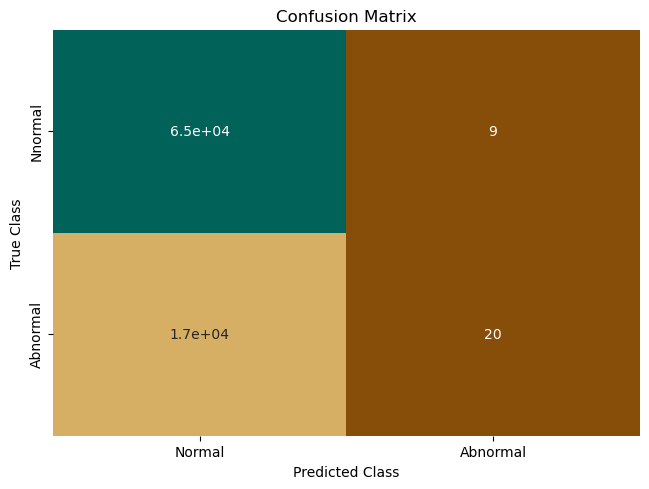

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

**Tip:** If the chart doesn't display the first time, try running the cell again.

If these results are good enough for your application, then the model might be good enough. However, because there are consequences from incorrectly predicting *Normal* values -- that is, no abnormality was found when there actually was one -- the focus should be on reducing this result.

# Step 3: Calculating performance statistics

If you want to compare this model to the next model that you create, you need some metrics that you can record. For a binary classification problem, the confusion matrix data can be used to calculate various metrics.

To start, extract the values from the confusion matrix cells into variables.

In [30]:

from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 64613
False Positive (FP): 9
False Negative (FN): 17137
True Positive (TP) : 20


You can now calculate some statistics.


### Sensitivity

*Sensitivity* is also known as *hit rate*, *recall*, or *true positive rate (TPR)*. It measures the proportion of the actual positives that are correctly identified.

In this example, the sensitivity is *the probablity of detecting an abnormality for patients with an abnormality*.

In [31]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 0.11657049600746051%
There is a 0.11657049600746051% chance of detecting patients with an abnormality have an abnormality


**Question:** Is the sensitivity good enough for this scenario?


### Specificity

The next statistic is *specificity*, which is also known as the *true negative*. It measures the proportion of the actual negatives that are correctly identified.

In this example, the specificity is *the probablity of detecting normal, for patients who are normal*.

In [32]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")


Specificity or TNR: 99.98607285444585%
There is a 99.98607285444585% chance of detecting normal patients are normal.


**Question:** Is this specificity too low, exactly right, or too high? What value  would you want to see here, given the scenario?



### Positive and negative predictive values

The *precision*, or *positive predictive value*, is the proportion of positive results.

In this example, the positive predictive value is *the probability that subjects with a positive screening test truly have an abnormality*.

In [33]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 68.96551724137932%
You have an abnormality, and the probablity that is correct is 68.96551724137932%


The *negative predictive value* is the proportion of negative results.

In this example, the negative predictive value is *the probability that subjects with a negative screening test truly have an abnormality*.

In [34]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 79.03730886850153%
You don't have an abnormality, but there is a 79.03730886850153% chance that is incorrect


Think about the impact of these values. If you were a patient, how worried should you be if the test for an abnormality was positive? On the opposite side, how reassured should you be if you tested negative?


### False positive rate

The *false positive rate (FPR)* is the probability that a false alarm will be raised, or that *a positive result will be given when the true value is negative*. 

In [35]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 0.013927145554145648%
There is a 0.013927145554145648% chance that this positive result is incorrect.


### False negative rate

The *false negative rate* -- or *miss rate* -- is *the probability that a true positive will be missed by the test*.

In [36]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 99.88342950399255%
There is a 99.88342950399255% chance that this negative result is incorrect.


### False discovery rate

In this example, the *false discovery rate* is *the probability of predicting an abnormality when the patient doesn't have one*.

In [37]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 31.03448275862069%
You have an abnormality, but there is a 31.03448275862069% chance this is incorrect.


### Overall accuracy

How accuracte is your model?

In [38]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 79.03373726751366%


In summary, you calculated the following metrics from your model:

In [39]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 0.11657049600746051%
Specificity or TNR: 99.98607285444585%
Precision: 68.96551724137932%
Negative Predictive Value: 79.03730886850153%
False Positive Rate: 0.013927145554145648%
False Negative Rate: 99.88342950399255%
False Discovery Rate: 31.03448275862069%
Accuracy: 79.03373726751366%


**Challenge task:** Record the previous values, then go back to step 1 and change the value used for the threshold. Values you should try are *.25* and *.75*. 

Did those threshold values make a difference?

# Step 4: Calculating the AUC-ROC Curve

The scikit-learn library has functions that can help you compute the *area under the receiver operating characteristic curve (AUC-ROC)*.

- The ROC is a probability curve.
- The AUC tells you how well the model can distinguish between classes. 

The AUC can be calculated. As you will see in the next lab, it can be used to measure the performance of the model. 

In this example, the higher the AUC, the better the model is at distinguishing between abnormal and normal patients.

Depending on the value you set for the threshold, the AUC can change. You can plot the AUC by using the probability instead of your converted class.


In [48]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted['binary']) )

Validation AUC 0.5005132167522666


Typically, the ROC curve is plotted with the TPR against the FPR, where the TPR is on the y-axis and the FPR is on the x-axis.

scikit-learn has the **roc_curve** function to help generate those values to plot.

ValueError: Axis limits cannot be NaN or Inf

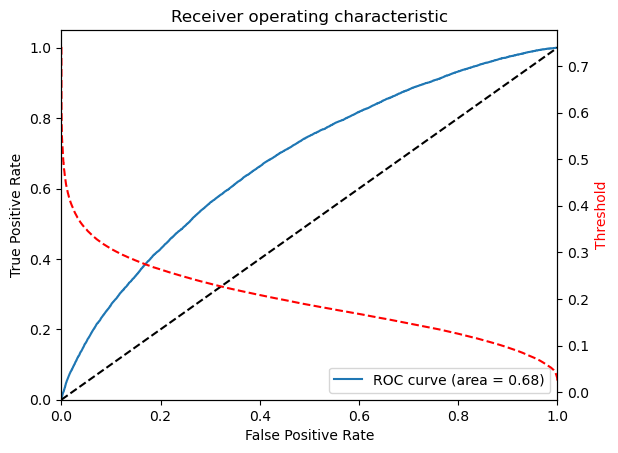

In [50]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted['binary'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())

**Challenge task:** Update the previous code to use *target_predicted_binary* instead of *target_predicted*. How does that change the graph? Which is the most useful?

In [51]:
import numpy as np
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    
    # Filter out any NaN or Inf values from thresholds
    filtered_thresholds = [t for t in thresholds if not np.isnan(t) and not np.isinf(t)]

    # Now set the ylim
    ax2.set_ylim([min(filtered_thresholds), max(filtered_thresholds)])

    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    
    
plot_confusion_matrix(test_labels, target_predicted_binary)
plot_roc(test_labels, target_predicted_binary)

<Figure size 640x480 with 0 Axes>

# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.

In [45]:
target_predicted

,class,binary
0,0.259868,0
1,0.317444,0
2,0.154833,0
3,0.325893,0
4,0.162553,0
...,...,...
81774,0.173660,0
81775,0.143641,0
81776,0.270534,0
81777,0.205831,0


In [ ]:
OMS Tools 

# Step 2: Creating a hyperparameter tuning job

A hyperparameter tuning job can take several hours to complete, depending on the value ranges that you provide. To simplify this task, the parameters used in this step are a subset of the recommended ranges. They were tuned to give good results in this lab, without taking multiple hours to complete.

For more information about the parameters to tune for XGBoost, see [Tune an XGBoost Model](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) in the AWS Documentation.

Because this next cell can take approximately **45** minutes to complete, go ahead and run the cell. You will examine what's happening, and why these hyperparameter ranges were chosen.

In [ ]:
%%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())


xgb.set_hyperparameters(eval_metric='error@.40',
                        objective='binary:logistic',
                        num_round=42)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:error'
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

First, you will create the model that you want to tune.

```
xgb = sagemaker.estimator.Estimator(container,
                                   role=sagemaker.get_execution_role(), 
                                   instance_count= 1, # make sure you have limit set for these instances
                                   instance_type='ml.m4.xlarge', 
                                   output_path='s3://{}/{}/output'.format(bucket, prefix),
                                   sagemaker_session=sagemaker.Session())

xgb.set_hyperparameters(eval_metric='[error@.40]',
                        objective='binary:logistic',
                        num_round=42)

```                        

Notice that the *eval_metric* of the model was changed to *error@.40*, with a goal of minimizing that value. 

**error** is the binary classification error rate. It's calculated as *#(wrong cases)/#(all cases)*. For predictions, the evaluation will consider the instances that have a prediction value larger than 0.4 to be positive instances, and the others as negative instances.

Next, you must specify the hyperparameters that you want to tune, in addition to the ranges that you must select for each parameter.

The hyperparameters that have the largest effect on XGBoost objective metrics are: 

- alpha
- min_child_weight
- subsample
- eta
- num_round 

The recommended tuning ranges can be found in the AWS Documentation at [Tune an XGBoost Model](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html).

For this lab, you will use a *subset* of values. These values were obtained by running the tuning job with the full range, then minimizing the range so that you can use fewer iterations to get better performance. Though this practice isn't strictly realistic, it prevents you from waiting several hours in this lab for the tuning job to complete.

```
hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }
```


You must specify how you are rating the model. You could use several different objective metrics, a subset of which applies to a binary classifcation problem. Because the evaluation metric is **error**, you set the objective to *error*.

```
objective_metric_name = 'validation:error'
objective_type = 'Minimize'
```

Finally, you run the tuning job.

```
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()
```



<i class="fas fa-exclamation-triangle" style="color:red"></i> Wait until the training job is finished. It might take up to **45** minutes. While you are waiting, observe the job status in the console, as described in the following instructions.

**To monitor hyperparameter optimization jobs:**  

1. In the AWS Management Console, on the **Services** menu, choose **Amazon SageMaker**.  
2. Choose **Training > Hyperparameter tuning jobs**.  
3. You can check the status of each hyperparameter tuning job, its objective metric value, and its logs.  

After the training job is finished, check the job and make sure that it completed successfully.

In [ ]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

# Step 3: Investigating the tuning job results

Now that the job is complete, there should be 10 completed jobs. One of the jobs should be marked as the best.

You can examine the metrics by getting *HyperparameterTuningJobAnalytics* and loading that data into a pandas DataFrame.


In [ ]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)


You should be able to see the hyperparameters that were used for each job, along with the score. You could use those parameters and create a model, or you can get the best model from the hyperparameter tuning job.

In [ ]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

Now, you must attach to the best training job and create the model.

In [ ]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})

Then, you can use the transform method to perform a batch prediction by using your testing data. Remember that the testing data is data that the model has never seen before.

In [ ]:
%%time
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)


xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

Get the predicted target and the test labels of the model.

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
best_target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = best_target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

Plot a confusion matrix for your `best_target_predicted` and `test_labels`.

In [ ]:
plot_confusion_matrix(test_labels, best_target_predicted_binary)

Plot the ROC chart.

In [ ]:
plot_roc(test_labels, best_target_predicted_binary)

**Question:** How do these results differ from the original? Are these results better or worse? 

You might not always see an improvement. There are a few reasons for this result:

- The model might already be good from the initial pass (what counts as *good* is subjective).
- You don't have a large amount of data to train with.
- You are using a *subset* of the hyperparameter tuning ranges to save time in this lab.

Increasing the hyperparameter ranges (as recommended by the documentation) and running more than 30 jobs will typically improve the model. However, this process will take 2-3 hours to complete.

# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.


